In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_addons as tfa

from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics, Model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import pathlib
import random
import nibabel as nib

import os, random, json, PIL, shutil, re, imageio, glob
from PIL import ImageDraw


## Initial parameters

In [2]:
BUFFER_SIZE = 5000
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 1
BATCH_SIZE = 4
EPOCHS = 28
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

## Preprocess datasets

In [3]:
def preprocess_image_T2(image):
    image= tf.image.decode_png(image, channels=1)
    image = tf.image.pad_to_bounding_box(image, offset_height=0, offset_width=0, target_height=256, target_width=256)
    image = tf.image.resize(image, [256, 256])
    image = tf.image.rot90(image, k=3) # rotate 270º
    image = tf.image.flip_up_down(image)
    image = (image-127.5)/127.5
    return image

def preprocess_image(image):
    image= tf.image.decode_png(image, channels=1)
    image = tf.image.pad_to_bounding_box(image, offset_height=0, offset_width=60, target_height=256, target_width=256)
    image = tf.image.resize(image, [256, 256])
    image = (image-127.5)/127.5
    return image

def preprocess_image_test(image):
    image= tf.image.decode_png(image, channels=1)
    image = tf.image.pad_to_bounding_box(image, offset_height=0, offset_width=0, target_height=256, target_width=256)
    image = tf.image.resize(image, [256, 256])
    image = (image-127.5)/127.5
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_image_test(path):
    image = tf.io.read_file(path)
    return preprocess_image_test(image)

def load_and_preprocess_image_T2(path):
    image = tf.io.read_file(path)
    return preprocess_image_T2(image)

In [4]:
data_root = pathlib.Path('../input/ixi-t1/image slice-T1')
all_image_paths_T1 = list(data_root.glob('*/*'))
all_image_paths_T1.sort()
new_all_image_paths_T1 = []
for i in range(len(all_image_paths_T1)):
    if (i+5)%10 == 0:
        new_all_image_paths_T1.append(all_image_paths_T1[i])
all_image_paths_T1 = new_all_image_paths_T1
all_image_paths_T1 = [str(path) for path in all_image_paths_T1[:500]]
image_count = len(all_image_paths_T1)
ds_T1 = tf.data.Dataset.from_tensor_slices((all_image_paths_T1))
dataset_T1 = ds_T1.map(load_and_preprocess_image).batch(BATCH_SIZE).repeat().shuffle(512)
dataset_T1 = dataset_T1.cache()
dataset_T1_test = ds_T1.map(load_and_preprocess_image).batch(1)

In [5]:
data_root = pathlib.Path('../input/ixit2-slices/image slice-T2')
all_image_paths_T2 = list(data_root.glob('*/*'))
all_image_paths_T2.sort()
new_all_image_paths_T2 = []
for i in range(len(all_image_paths_T2)):
    if (i+4)%10 == 0:
        new_all_image_paths_T2.append(all_image_paths_T2[i])
all_image_paths_T2 = new_all_image_paths_T2
all_image_paths_T2 = [str(path) for path in all_image_paths_T2[:500]]
#random.shuffle(all_image_paths)
image_count = len(all_image_paths_T2)
ds_T2 = tf.data.Dataset.from_tensor_slices((all_image_paths_T2))
dataset_T2 = ds_T2.map(load_and_preprocess_image_T2).batch(BATCH_SIZE).repeat().shuffle(512)
dataset_T2 = dataset_T2.cache()
dataset_T2_test = ds_T2.map(load_and_preprocess_image_T2).batch(1)

# Build the generator


In [6]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=layers.ReLU(), name='block_x'):
    block = layers.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = layers.ReLU()(block)
    
    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = layers.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = layers.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = layers.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.ReLU()(block)
    
    return block

In [7]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 1
    inputs = layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = layers.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
sample_generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
encoder_block_1 (Conv2D)        (None, 256, 256, 64) 3136        input_image[0][0]                
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 256, 256, 64) 0           encoder_block_1[0][0]            
__________________________________________________________________________________________________
encoder_block_2 (Conv2D)        (None, 128, 128, 128 73728       re_lu_1[0][0]                    
______________________________________________________________________________________________

In [8]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = layers.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=layers.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_block_1 (Conv2D)     (None, 128, 128, 64)      1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_block_2 (Conv2D)     (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_4 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
encoder_block_3 (Conv2D)     (None, 32, 32, 256)       5242

# Build the discriminator

In [9]:

T1_generator = generator_fn() # transforms T2 to T1
T2_generator = generator_fn() # transforms T1 paintings to be T2

T1_discriminator = discriminator_fn() # differentiates real T1 and generated T1
T2_discriminator = discriminator_fn() # differentiates real T2 and generated T2


## Load saved models to continue training, if new training, set it to Markdown

In [10]:
T1_generator = tf.keras.models.load_model('../input/mri-transform-model/T1/generateT1_3_25')
T1_discriminator = tf.keras.models.load_model('../input/mri-transform-model/T1/discriminateT1_3_25')

T2_generator = tf.keras.models.load_model('../input/mri-transform-model/T2/generateT2_3_25')
T2_discriminator = tf.keras.models.load_model('../input/mri-transform-model/T2/discriminateT2_3_25')

## Build the model

In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        T1_generator,
        T2_generator,
        T1_discriminator,
        T2_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.T1_gen = T1_generator
        self.T2_gen = T2_generator
        self.T1_disc = T1_discriminator
        self.T2_disc = T2_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        T1_gen_optimizer,
        T2_gen_optimizer,
        T1_disc_optimizer,
        T2_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.T1_gen_optimizer = T1_gen_optimizer
        self.T2_gen_optimizer = T2_gen_optimizer
        self.T1_disc_optimizer = T1_disc_optimizer
        self.T2_disc_optimizer = T2_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_T1, real_T2 = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # T2 to T1 back to T2
            fake_T1 = self.T1_gen(real_T2, training=True)
            cycled_T2 = self.T2_gen(fake_T1, training=True)

            # T1 to T2 back to T1
            fake_T2 = self.T2_gen(real_T1, training=True)
            cycled_T1 = self.T1_gen(fake_T2, training=True)

            # generating itself
            same_T1 = self.T1_gen(real_T1, training=True)
            same_T2 = self.T2_gen(real_T2, training=True)

            # discriminator used to check, inputing real images
            disc_real_T1 = self.T1_disc(real_T1, training=True)
            disc_real_T2 = self.T2_disc(real_T2, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_T1 = self.T1_disc(fake_T1, training=True)
            disc_fake_T2 = self.T2_disc(fake_T2, training=True)

            # evaluates generator loss
            T1_gen_loss = self.gen_loss_fn(disc_fake_T1)
            T2_gen_loss = self.gen_loss_fn(disc_fake_T2)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_T1, cycled_T1, self.lambda_cycle) + self.cycle_loss_fn(real_T2, cycled_T2, self.lambda_cycle)

            # evaluates total generator loss
            total_T1_gen_loss = T1_gen_loss + total_cycle_loss + self.identity_loss_fn(real_T1, same_T1, self.lambda_cycle)
            total_T2_gen_loss = T2_gen_loss + total_cycle_loss + self.identity_loss_fn(real_T2, same_T2, self.lambda_cycle)

            # evaluates discriminator loss
            T1_disc_loss = self.disc_loss_fn(disc_real_T1, disc_fake_T1)
            T2_disc_loss = self.disc_loss_fn(disc_real_T2, disc_fake_T2)

        # Calculate the gradients for generator and discriminator
        T1_generator_gradients = tape.gradient(total_T1_gen_loss,
                                                  self.T1_gen.trainable_variables)
        T2_generator_gradients = tape.gradient(total_T2_gen_loss,
                                                  self.T2_gen.trainable_variables)

        T1_discriminator_gradients = tape.gradient(T1_disc_loss,
                                                      self.T1_disc.trainable_variables)
        T2_discriminator_gradients = tape.gradient(T2_disc_loss,
                                                      self.T2_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.T1_gen_optimizer.apply_gradients(zip(T1_generator_gradients,
                                                 self.T1_gen.trainable_variables))

        self.T2_gen_optimizer.apply_gradients(zip(T2_generator_gradients,
                                                 self.T2_gen.trainable_variables))

        self.T1_disc_optimizer.apply_gradients(zip(T1_discriminator_gradients,
                                                  self.T1_disc.trainable_variables))

        self.T2_disc_optimizer.apply_gradients(zip(T2_discriminator_gradients,
                                                  self.T2_disc.trainable_variables))
        
        return {
            "T1_gen_loss": total_T1_gen_loss,
            "T2_gen_loss": total_T2_gen_loss,
            "T1_disc_loss": T1_disc_loss,
            "T2_disc_loss": T2_disc_loss
        }

## loss function

In [12]:
def discriminator_loss(real, generated):
     real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

     generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

     total_disc_loss = real_loss + generated_loss

     return total_disc_loss * 0.5

In [13]:
 def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [14]:
 def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [15]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## decrease the learning rate with epochs increasing

28 total epochs and 125 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 1.43e-05


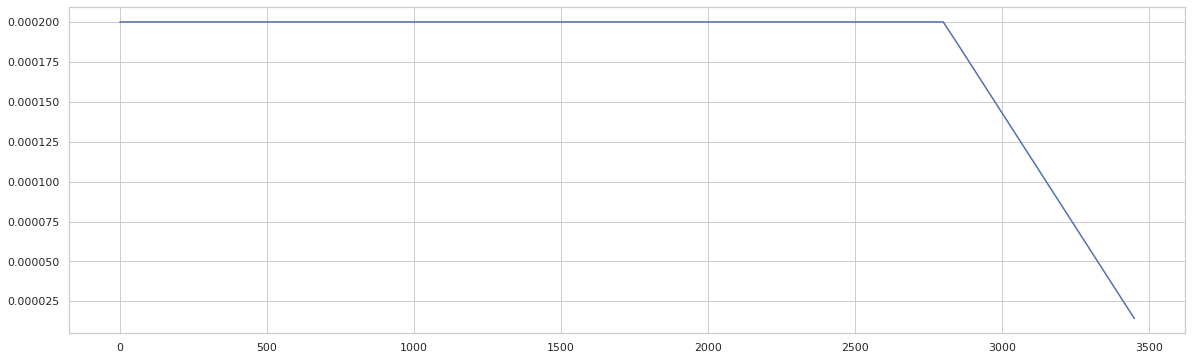

In [16]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(500, 500)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(500, 500)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [17]:

lr_T1_gen = lambda: linear_schedule_with_warmup(tf.cast(T1_generator_optimizer.iterations, tf.float32))
lr_T2_gen = lambda: linear_schedule_with_warmup(tf.cast(T2_generator_optimizer.iterations, tf.float32))
    
T1_generator_optimizer = optimizers.Adam(learning_rate=lr_T1_gen, beta_1=0.5)
T2_generator_optimizer = optimizers.Adam(learning_rate=lr_T2_gen, beta_1=0.5)

    # Create discriminators
lr_T1_disc = lambda: linear_schedule_with_warmup(tf.cast(T1_discriminator_optimizer.iterations, tf.float32))
lr_T2_disc = lambda: linear_schedule_with_warmup(tf.cast(T2_discriminator_optimizer.iterations, tf.float32))
    
T1_discriminator_optimizer = optimizers.Adam(learning_rate=lr_T1_disc, beta_1=0.5)
T2_discriminator_optimizer = optimizers.Adam(learning_rate=lr_T2_disc, beta_1=0.5)

    
    # Create GAN
gan_model = CycleGan(T1_generator, T2_generator, 
                     T1_discriminator, T2_discriminator)

gan_model.compile(T1_gen_optimizer=T1_generator_optimizer,
                      T2_gen_optimizer=T2_generator_optimizer,
                      T1_disc_optimizer=T1_discriminator_optimizer,
                      T2_disc_optimizer=T2_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

## Build callback, save model and figures at some epoches end

In [18]:
# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4, T1_path='T1', T2_path='T2'):
        self.num_img = num_img
        self.T1_path = T1_path
        self.T2_path = T2_path
        # Create directories to save the generate images
        if not os.path.exists(self.T1_path):
            os.makedirs(self.T1_path)
        if not os.path.exists(self.T2_path):
            os.makedirs(self.T2_path)

    def on_epoch_end(self, epoch, logs=None):
        if epoch%7 == 0:
            fig = plt.figure(figsize=(12,8))
            for i, img in enumerate(dataset_T2_test.take(self.num_img)):
                prediction = T1_generator(img, training=False).numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                cycle = T2_generator(prediction, training=False)
                plt.subplot(6,4,i +1)
                plt.imshow(img[0], cmap = 'gray')
                plt.axis('off')
                plt.subplot(6,4,i +5)
                plt.imshow(prediction[0], cmap = 'gray')
                plt.axis('off')
                plt.subplot(6,4,i +9)
                plt.imshow(cycle[0], cmap = 'gray')
                plt.axis('off')
            
        # Photo generated images
            for i, img in enumerate(dataset_T1_test.take(self.num_img)):
                prediction = T2_generator(img, training=False).numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                cycle = T1_generator(prediction, training=False)
                plt.subplot(6,4,i + 13)
                plt.imshow(img[0], cmap = 'gray')
                plt.axis('off')
                plt.subplot(6,4,i + 17)
                plt.imshow(prediction[0], cmap = 'gray')
                plt.axis('off')
                plt.subplot(6,4,i + 21)
                plt.imshow(cycle[0], cmap = 'gray')
                plt.axis('off')
            plt.show()
            plt.savefig(f'{self.T1_path}/visualiation_{i}_{epoch+1}')
        if epoch%7 == 0:
            tf.keras.models.save_model(T1_generator, f'{self.T1_path}/generateT1_{i}_{epoch+1}')
            tf.keras.models.save_model(T1_discriminator, f'{self.T1_path}/discriminateT1_{i}_{epoch+1}')
            tf.keras.models.save_model(T2_generator, f'{self.T2_path}/generateT2_{i}_{epoch+1}')
            tf.keras.models.save_model(T2_discriminator, f'{self.T2_path}/discriminateT2_{i}_{epoch+1}')

## Train model

In [19]:
gan_ds = tf.data.Dataset.zip((dataset_T1, dataset_T2))

Epoch 1/28
125/125 [==============================] - 159s 935ms/step - T1_gen_loss: 2.5178 - T2_gen_loss: 3.4183 - T1_disc_loss: 0.5331 - T2_disc_loss: 0.3249


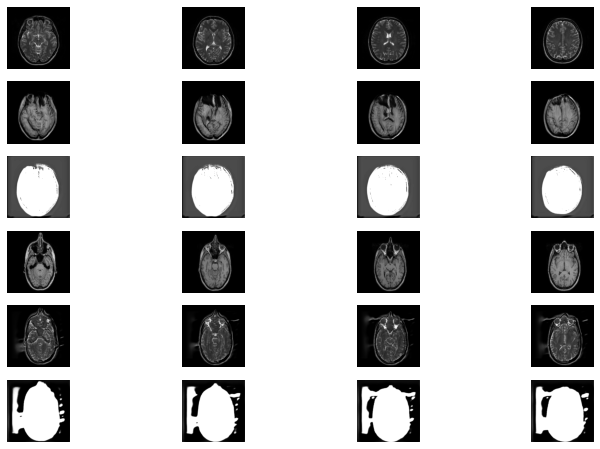

Epoch 2/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5893 - T2_gen_loss: 3.5056 - T1_disc_loss: 0.5438 - T2_disc_loss: 0.3391
Epoch 3/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5937 - T2_gen_loss: 3.4072 - T1_disc_loss: 0.5308 - T2_disc_loss: 0.3544
Epoch 4/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5322 - T2_gen_loss: 3.3556 - T1_disc_loss: 0.5428 - T2_disc_loss: 0.3645
Epoch 5/28
125/125 [==============================] - 118s 942ms/step - T1_gen_loss: 2.5543 - T2_gen_loss: 3.2606 - T1_disc_loss: 0.5367 - T2_disc_loss: 0.4196
Epoch 6/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5819 - T2_gen_loss: 3.2220 - T1_disc_loss: 0.5321 - T2_disc_loss: 0.3804
Epoch 7/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5665 - T2_gen_loss: 3.2388 - T1_disc_loss: 0.5246 - T2_disc_loss: 0.3990
Epoch 8/28
125/125 [====================

<Figure size 432x288 with 0 Axes>

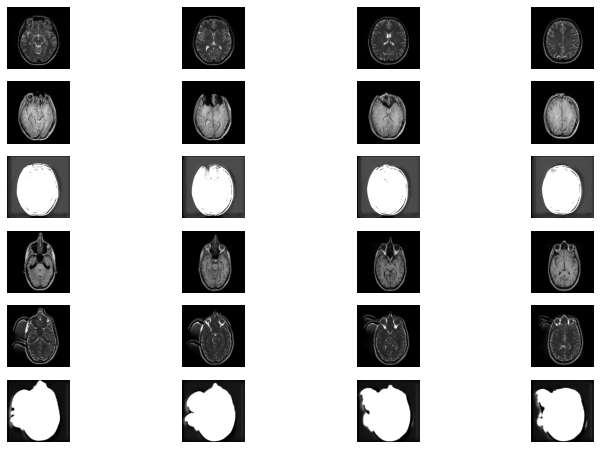

Epoch 9/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.6284 - T2_gen_loss: 3.2225 - T1_disc_loss: 0.5125 - T2_disc_loss: 0.3999
Epoch 10/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5888 - T2_gen_loss: 3.1900 - T1_disc_loss: 0.5125 - T2_disc_loss: 0.3870
Epoch 11/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.6429 - T2_gen_loss: 3.2714 - T1_disc_loss: 0.5113 - T2_disc_loss: 0.3944
Epoch 12/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.6183 - T2_gen_loss: 3.2017 - T1_disc_loss: 0.5227 - T2_disc_loss: 0.4218
Epoch 13/28
125/125 [==============================] - 119s 951ms/step - T1_gen_loss: 2.6257 - T2_gen_loss: 3.2428 - T1_disc_loss: 0.5293 - T2_disc_loss: 0.4139
Epoch 14/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.6069 - T2_gen_loss: 3.1579 - T1_disc_loss: 0.5379 - T2_disc_loss: 0.4391
Epoch 15/28
125/125 [==============

<Figure size 432x288 with 0 Axes>

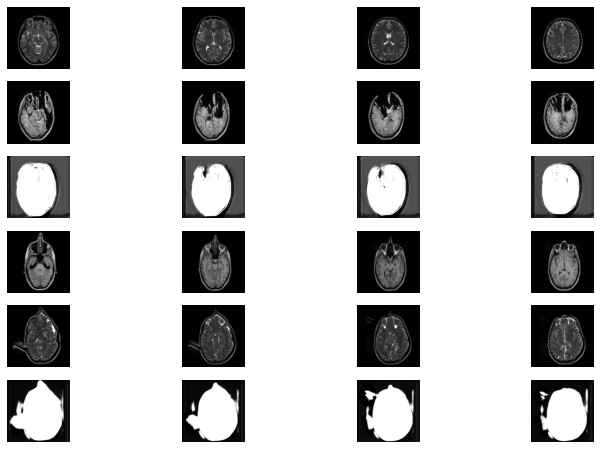

Epoch 16/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5400 - T2_gen_loss: 3.1613 - T1_disc_loss: 0.5557 - T2_disc_loss: 0.4372
Epoch 17/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5922 - T2_gen_loss: 3.1041 - T1_disc_loss: 0.5356 - T2_disc_loss: 0.4385
Epoch 18/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.6100 - T2_gen_loss: 3.1473 - T1_disc_loss: 0.5486 - T2_disc_loss: 0.4464
Epoch 19/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5963 - T2_gen_loss: 3.1547 - T1_disc_loss: 0.5468 - T2_disc_loss: 0.4521
Epoch 20/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.6168 - T2_gen_loss: 3.1155 - T1_disc_loss: 0.5290 - T2_disc_loss: 0.4468
Epoch 21/28
125/125 [==============================] - 117s 935ms/step - T1_gen_loss: 2.5842 - T2_gen_loss: 3.0456 - T1_disc_loss: 0.5509 - T2_disc_loss: 0.4768
Epoch 22/28
125/125 [=============

<Figure size 432x288 with 0 Axes>

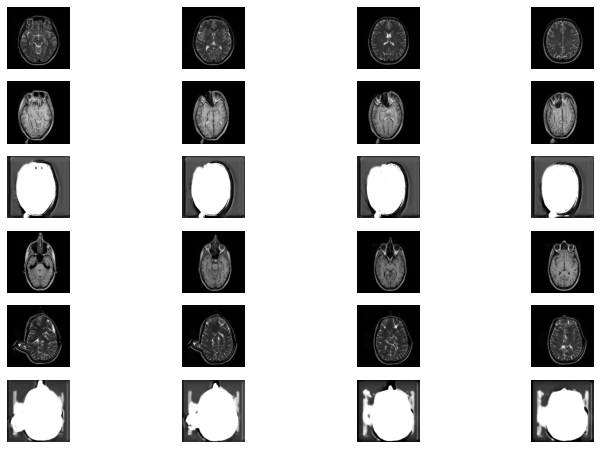

Epoch 23/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5896 - T2_gen_loss: 3.0296 - T1_disc_loss: 0.5271 - T2_disc_loss: 0.4497
Epoch 24/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5398 - T2_gen_loss: 2.9629 - T1_disc_loss: 0.5275 - T2_disc_loss: 0.4416
Epoch 25/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5414 - T2_gen_loss: 2.9254 - T1_disc_loss: 0.5063 - T2_disc_loss: 0.4380
Epoch 26/28
125/125 [==============================] - 117s 933ms/step - T1_gen_loss: 2.5209 - T2_gen_loss: 2.9371 - T1_disc_loss: 0.5007 - T2_disc_loss: 0.4059
Epoch 27/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.5168 - T2_gen_loss: 2.8727 - T1_disc_loss: 0.4803 - T2_disc_loss: 0.3930
Epoch 28/28
125/125 [==============================] - 117s 934ms/step - T1_gen_loss: 2.4683 - T2_gen_loss: 2.7976 - T1_disc_loss: 0.4764 - T2_disc_loss: 0.3977


<Figure size 432x288 with 0 Axes>

In [20]:
 history =   gan_model.fit( gan_ds,
                            epochs=EPOCHS,
                            callbacks=[GANMonitor()],
                            steps_per_epoch=(max(500, 500)//BATCH_SIZE) ).history    

## estimate models by PSNR,SSIM

In [21]:
test_ds = tf.data.Dataset.zip((dataset_T1_test, dataset_T2_test)).shuffle(10)

In [22]:
def estimation_generator_T1(T1_generator, test_ds, change_size = None):
    fig = plt.figure(figsize= (16,5)) 
    psnr = []
    ssim = []

    for i, img in enumerate(test_ds.take(8)): 
        image_T1, image_T2 = img
        generated_T1 = T1_generator(image_T2)
        if change_size == True:
            generated_T1 = generated_T1+1
            generated_T1 = tf.image.resize(generated_T1, [256, 150])
            generated_T1 = tf.image.pad_to_bounding_box(generated_T1, offset_height=0, offset_width=60, target_height=256, target_width=256)
            generated_T1 = generated_T1-1
            
        plt.subplot(2,8,(i+1))
        plt.imshow(image_T2[0], cmap = 'gray')
        plt.title('T2 image')
        plt.axis('off')
        plt.subplot(2,8, (i+9))
        plt.imshow(generated_T1[0], cmap = 'gray')
        plt.title('Generated \n T1 image')
        plt.axis('off')
    
    for i, img in enumerate(test_ds.take(100)):   
        image_T1, image_T2 = img
        if change_size == True:
            generated_T1 = generated_T1+1
            generated_T1 = tf.image.resize(generated_T1, [256, 150])
            generated_T1 = tf.image.pad_to_bounding_box(generated_T1, offset_height=0, offset_width=60, target_height=256, target_width=256)
            generated_T1 = generated_T1-1  
        psnr.append( tf.image.psnr(generated_T1, image_T1, max_val=2))
        ssim.append( tf.image.ssim(generated_T1, image_T1, max_val=2))

    psnr_mean = np.mean(psnr)
    psnr_std = np.std(psnr, ddof=1)
    ssim_mean = np.mean(ssim) 
    ssim_std = np.std(ssim, ddof=1)
    print('========T2 to T1 =========')
    print('PSNR ={}, std ={}'.format(psnr_mean, psnr_std))
    print('SSIM ={}, std ={}'.format(ssim_mean, ssim_std))
    plt.show()
    
    
def estimation_generator_T2(T2_generator, test_ds, change_size = None):
    fig = plt.figure(figsize= (16,5)) 
    psnr = []
    ssim = []

    for i, img in enumerate(test_ds.take(8)): 
        image_T1, image_T2 = img
        if change_size == True:
            image_T1= tf.image.crop_to_bounding_box(image_T1, offset_height=0, offset_width=60, target_height=256, target_width=150)
            image_T1 = tf.image.resize(image_T1, [256, 256])
            
        generated_T2 = T2_generator(image_T1)
        if change_size == True:
            image_T1 = image_T1+1
            image_T1 = tf.image.resize(image_T1, [256, 150])
            image_T1 = tf.image.pad_to_bounding_box(image_T1, offset_height=0, offset_width=60, target_height=256, target_width=256)
            image_T1 = image_T1-1  
        plt.subplot(2,8,(i+1))
        plt.imshow(image_T1[0], cmap = 'gray')
        plt.title('T1 image')
        plt.axis('off')
        plt.subplot(2,8, (i+9))
        plt.imshow(generated_T2[0], cmap = 'gray')
        plt.title('Generated \n T2 image')
        plt.axis('off')
    
    for i, img in enumerate(test_ds.take(100)):   
        image_T1, image_T2 = img
        if change_size == True:
            image_T1= tf.image.crop_to_bounding_box(image_T1, offset_height=0, offset_width=60, target_height=256, target_width=150)
            image_T1 = tf.image.resize(image_T1, [256, 256])
        generated_T2 = T2_generator(image_T1)
        if change_size == True:
            image_T1 = image_T1+1
            image_T1 = tf.image.resize(image_T1, [256, 150])
            image_T1 = tf.image.pad_to_bounding_box(image_T1, offset_height=0, offset_width=60, target_height=256, target_width=256)
            image_T1 = image_T1-1  
        psnr.append( tf.image.psnr(generated_T2, image_T2, max_val=2))
        ssim.append( tf.image.ssim(generated_T2, image_T2, max_val=2))

    psnr_mean = np.mean(psnr)
    psnr_std = np.std(psnr, ddof=1)
    ssim_mean = np.mean(ssim) 
    ssim_std = np.std(ssim, ddof=1)
    print('========T1 to T2 =========')
    print('PSNR ={}, std ={}'.format(psnr_mean, psnr_std))
    print('SSIM ={}, std ={}'.format(ssim_mean, ssim_std))
    plt.show()

========T1 to T2 =========
PSNR =16.5729923248291, std =0.682974636554718
SSIM =0.5307311415672302, std =0.029891468584537506


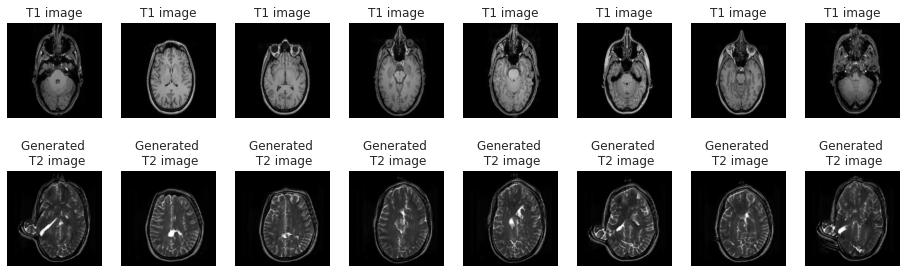

========T2 to T1 =========
PSNR =13.991472244262695, std =0.44909733533859253
SSIM =0.5038099884986877, std =0.015158065594732761


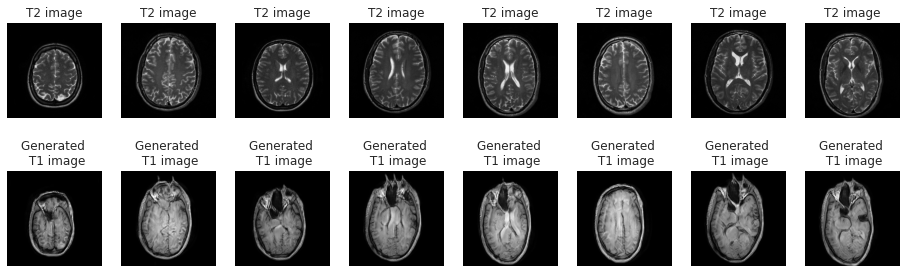

In [23]:
estimation_generator_T2(T2_generator, test_ds)
estimation_generator_T1(T1_generator, test_ds)

## Estimate previous models

## DC-GAN model

In [24]:
T1_generator_DC = tf.keras.models.load_model('../input/dcganmodel/model_v1/model_G_A12000')

========T2 to T1 =========
PSNR =13.247920036315918, std =1.5851731300354004
SSIM =0.639376163482666, std =0.043351851403713226


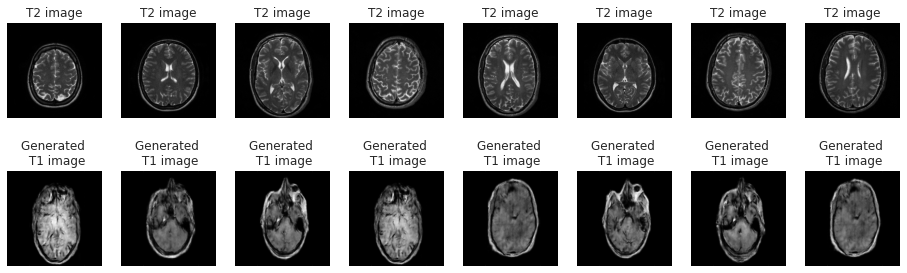

In [25]:
estimation_generator_T1(T1_generator_DC, test_ds, change_size=True)

## Cycle-gan

========T2 to T1 =========
PSNR =13.178683280944824, std =1.5612256526947021
SSIM =0.6380666494369507, std =0.043705280870199203


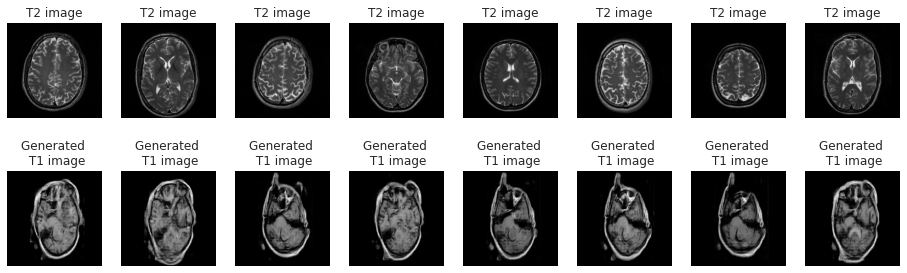

========T1 to T2 =========
PSNR =16.79448699951172, std =0.6527225971221924
SSIM =0.5491189956665039, std =0.020747249945998192


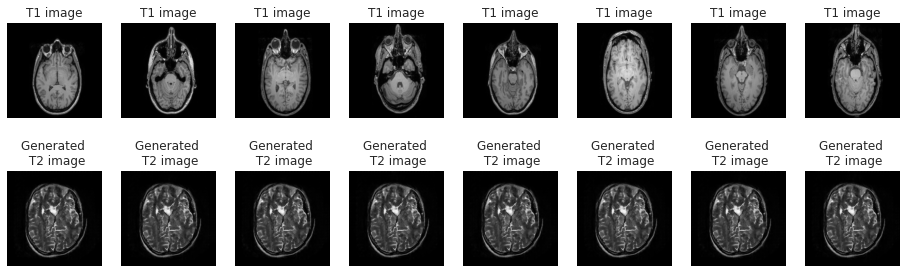

In [26]:
T1_generator_cycle = tf.keras.models.load_model('../input/cycle-gan-model/cyclegan-model/generatorT1_1')
estimation_generator_T1(T1_generator_cycle, test_ds, change_size=True)
T1_generator_cycle = tf.keras.models.load_model('../input/cycle-gan-model/cyclegan-model/generatorT2_1')
estimation_generator_T2(T1_generator_cycle, test_ds, change_size=True)

## U-net

========T2 to T1 =========
PSNR =13.799190521240234, std =0.49231547117233276
SSIM =0.5121686458587646, std =0.018373722210526466


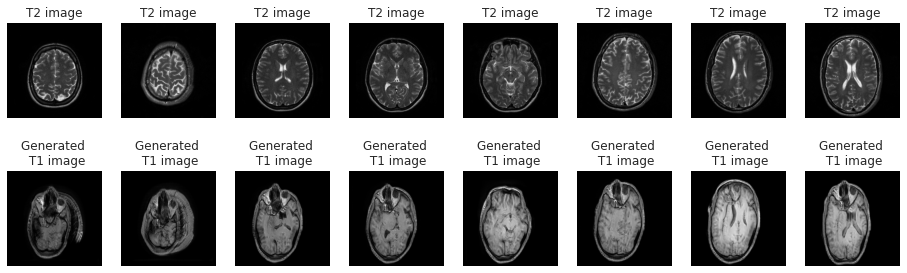

In [27]:
T1_generator_unet = tf.keras.models.load_model('../input/unet-model/T1/generateT1_3_25')
estimation_generator_T1(T1_generator_unet, test_ds)